# Intergalactic propagation of gamma rays

This notebook exemplifies how to simulate the propagation of gamma ray over cosmological distances
It considers an astrophysical object at a given distance emitting gamma rays according to a power law $E^{-\alpha}$, with an exponential cut-off at a characteristic energy $E_\mathrm{max}$.
The simulation is done assuming this spectrum to be E^-1, but at the post-processing stage any desired spectral index can be obtained.
The object in question is the extreme blazar 1ES 0229+200.

### Assembling the simulation

The assemblage of the simulation modules goes as in example 3. 
We define a source, which generates a sample of candidates according to the chosen distributions to be propagated.
We then add all relevant propagation modules (for motion, interactions, decays, etc), and an observer, in addition to the break conditions.

(This simulation can take up to 10 minutes, depending on the machine.)

In [1]:
from crpropa import *

# general options
nEvents = 10000
energyMinimum = 1 * GeV
energyMaximum = 400 * TeV
redshift = 0.14
distance = redshift2ComovingDistance(redshift)
electrons = photons = True
thinning = 1.
cmb = CMB()
ebl = IRB_Gilmore12()
outputFile = 'sim/04-sim_gamma1D.txt'

# source distribution: uniform with power-law spectrum
position = SourcePosition(Vector3d(distance, 0, 0))
direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
redshifts = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
energySpectrum = SourcePowerLawSpectrum(energyMinimum, energyMaximum, -1)
particleType = SourceParticleType(22) # we are interested in gamma rays
source = Source()
source.add(position)
source.add(redshifts) 
source.add(direction)
source.add(energySpectrum)
source.add(particleType)

# output
outputType = Output.Event1D
output = TextOutput(outputFile, outputType)
output.disable(output.CandidateTagColumn)
output.enable(output.WeightColumn) # since we are using thinning
output.setEnergyScale(eV)
output.setLengthScale(Mpc)

# observer 
observerType = Observer1D()
observer = Observer()
observer.add(observerType)
observer.onDetection(output)

# interactions
ppCMB = EMPairProduction(cmb, electrons, thinning)
ppEBL = EMPairProduction(ebl, electrons, thinning)
icsCMB = EMInverseComptonScattering(cmb, photons, thinning)
icsEBL = EMInverseComptonScattering(ebl, photons, thinning)
z = Redshift()
processes = [ppCMB, ppEBL, icsCMB, icsEBL, z]

# propagator: one-dimensional
propagator = SimplePropagation(0.1 * kpc, 100 * kpc)

# break conditions
breakEnergy = MinimumEnergy(1 * GeV)

# assemble simulation components
sim = ModuleList()
sim.add(propagator)
for interaction in processes:
	sim.add(interaction)
sim.add(observer)
sim.add(breakEnergy)
sim.setShowProgress(True)
sim.run(source, nEvents, True)

output.close()


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Mon Aug 21 19:24:58 2023 : [ Finished ] 100%    Needed: 00:07:28  - Finished at Mon Aug 21 19:32:26 2023


### Helper functions

Here we define some functions to read the simulations and compute the spectrum.
This includes de reweighting procedure to take the simulations from the way it was done (spectrum $E^{-1}$ without a cut-off), to the desired scenario (spectrum $E^{-\alpha}$ with exponential cut-off at $E_\text{max}$).
Because thinning was used to speed up this simulation, the weights should also take into account the intrinsic weights of the simulation due to thinning.

In [2]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(outputFile, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Emax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Emax`: spectrum cuts off above Emax \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (Emax))
	w = np.array([computeWeight(e0) for e0, w0 in zip(df['E0'], df['W'])])
	df[columnName] = w / np.sum(w)

def computeSpectrum(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.
	Note that 

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(9, 15, 20)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

### Analysis

Here we analyse the simulations and post-process them, applying the appropriate reweighting procedure.

In [3]:
data = readSimulation(outputFile)
reweightSimulation(data, 1.5, 1e12, columnName = 'W1')
reweightSimulation(data, 1.5, 1e13, columnName = 'W2')
reweightSimulation(data, 1.5, 1e14, columnName = 'W3')
reweightSimulation(data, 2.0, 1e12, columnName = 'W4')
reweightSimulation(data, 2.0, 1e13, columnName = 'W5')
reweightSimulation(data, 2.0, 1e14, columnName = 'W6')
x1, y1 = computeSpectrum(data, columnName = 'W1')
x2, y2 = computeSpectrum(data, columnName = 'W2')
x3, y3 = computeSpectrum(data, columnName = 'W3')
x4, y4 = computeSpectrum(data, columnName = 'W4')
x5, y5 = computeSpectrum(data, columnName = 'W5')
x6, y6 = computeSpectrum(data, columnName = 'W6')


### Plotting

Now we will plot the spectrum for this object.

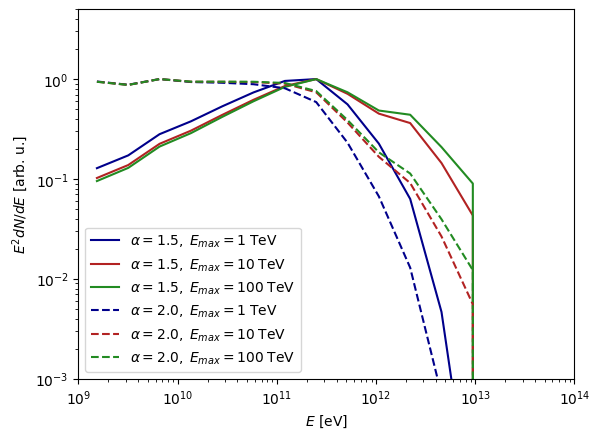

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

c1, c2, c3 = 'darkblue', 'firebrick', 'forestgreen'
ls1, ls2 = '-', '--'

plt.plot(x1, y1, ls = ls1, c = c1, label = '$\\alpha = 1.5, \\; E_{max} = 1 \\; \\mathrm{TeV}$')
plt.plot(x2, y2, ls = ls1, c = c2, label = '$\\alpha = 1.5, \\; E_{max} = 10 \\; \\mathrm{TeV}$')
plt.plot(x3, y3, ls = ls1, c = c3, label = '$\\alpha = 1.5, \\; E_{max} = 100 \\; \\mathrm{TeV}$')
plt.plot(x4, y4, ls = ls2, c = c1, label = '$\\alpha = 2.0, \\; E_{max} = 1 \\; \\mathrm{TeV}$')
plt.plot(x5, y5, ls = ls2, c = c2, label = '$\\alpha = 2.0, \\; E_{max} = 10 \\; \\mathrm{TeV}$')
plt.plot(x6, y6, ls = ls2, c = c3, label = '$\\alpha = 2.0, \\; E_{max} = 100 \\; \\mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e9, 1e14)
plt.ylim(1e-3, 5)
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.legend(loc = 'lower left')
plt.show()

